# 다중퍼셉트론을 이용한 손글씨 분류


다중 퍼셉트론 모델을 이용하여 MNIST 데이터를 분류하는 다층 퍼셉트롭을 구현한다.

## 0.환경설정

In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


+ 가로 세로 각각 28 pix

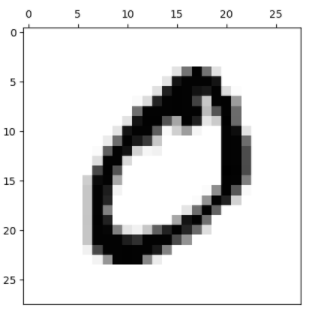

## 1.데이터 불러오기

MNIST 손글씨 실습을 위해 케라스에서 제공하는 MNIST 데이터 셋을 사용한다.

+ 학습 데이터에는 총 60,000개의 샘플이 있고 테스트 데이터는 총 10,000개의 샘플이 있다.
+ MNIST 데이터는 28개의 행과 28개의 열을 갖는 픽셀 데이터이다. 각 픽셀은 흑백 사진과 같이 0부터 255까지의 그레이스케일을 가지고 있다.

    28*28 = 784, 0~255 -> 256개 -> 2의 8제곱
    
    숫자 사진 1개의 용량 : 28 * 28 * 256 (bit)

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
print(x_train.shape, y_train.shape) # 학습 데이터
print(x_test.shape, y_test.shape)   # 학습이 완료된 후 테스트 데이터

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


## 2.학습 데이터와 검증 데이터 분리

+ 학습 데이터를 학습 데이터(5만개)와 검증 데이터(1만개)로 분리한다
+ 학습 중간마다 검증 데이터로 모델의 성능을 측정하면 모델 학습이 제대로 진행되는지 검증 정확도를 알 수 있고 학습 정확도는 올라가는데 검증 정확도가 안 올라가거나 떨어지는 경우 조기 종료를 구현할 수 있다.

In [4]:
x_val = x_train[50000:]
x_train = x_train[:50000]

y_val = y_train[50000:]
y_train = y_train[:50000]

학습 데이터를 출력해보면 데이터가 0부터 255까지의 숫자(그레이스케일)로 구성된 것을 확인할 수 있다.

In [5]:
# print(x_train[0])
for i in x_train[1]:
    for j in i:
        print('%3d ' % j, end='')
    print()

print(y_train[0])

  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  51 159 253 159  50   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252 253 122   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0 163 252 252 252 253 252 252  96 189 253 167   0   0 

## 3. 데이터 가공

### 3.1. 구조 변경

+ 다중 퍼셉트론의 입력값으로 들어갈 수 있도록 2차원 형태의 데이터를 1차원 배열 형태로 구조를 변경한다.

In [6]:
# 28 * 28 픽셀의 단색 이미지이므로 데이터 형태를 784개의 1차원 배열 형태로 변환한다.
# 샘플개수, 너비 * 높이 형태로 배
열을 구성한다
x_train = np.reshape(x_train, (50000, 784))
x_val = np.reshape(x_val, (10000, 784))
x_test = np.reshape(x_test, (10000, 784))

print(x_train.shape)

(50000, 784)


### 3.2. 정규화

+ 1차원으로 변경된 데이터를 그대로 다중 퍼셉트론에 입력해도 되지만 좀 더 효율적인 학습을 위해 데이터를 정규화시킨다
+ 정규화는 모델의 학습 시간을 단축시키고 더 나은 성능을 보이게 하는 효과가 있다
+ MNIST 데이터의 모든 값은 0부터 255까지의 범위 안에 있으므로 255로 나눠 모든 값을 0부터 1사인의 값으로 정규화한다.

In [7]:
print(type(x_train))
print(type(x_train[0][0]))

x_train = x_train.astype('float32')
print(type(x_train))
print(type(x_train[0][0]))

<class 'numpy.ndarray'>
<class 'numpy.uint8'>
<class 'numpy.ndarray'>
<class 'numpy.float32'>


In [8]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

global_scale  = 255

x_train /= global_scale
x_val /= global_scale
x_test /= global_scale

## 4. 모델 구현

+ MNIST 손글씨 데이터 분류 모델은 0부터 9까지의 숫자로 분류하는 다중 모델이므로 손실 함수로 크로스 엔트로피를 사용한다.

### 4.1. 원 핫 인코딩

+ 크로스 엔트로피를 계산하기 위해 실제값(y)은 원 핫 인코딩으로 변환한다.
+ 원 핫 인코딩(One Hot Encoding)은 데이터를 수많은 0과 1개의 1값으로 데이터를 구별하는 인코딩  방식으로 0으로 이루어진 벡터 집합에 단 1개의 1의 값으로 해당 데이터를 구별하는 것을 말한다.

In [9]:
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [10]:
# print(y_train[:5]) => [5 0 4 1 9]
for i in y_train[:5]:
    print(i)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


### 4.2. 다중퍼셉트론 구현 - 히든 레이어

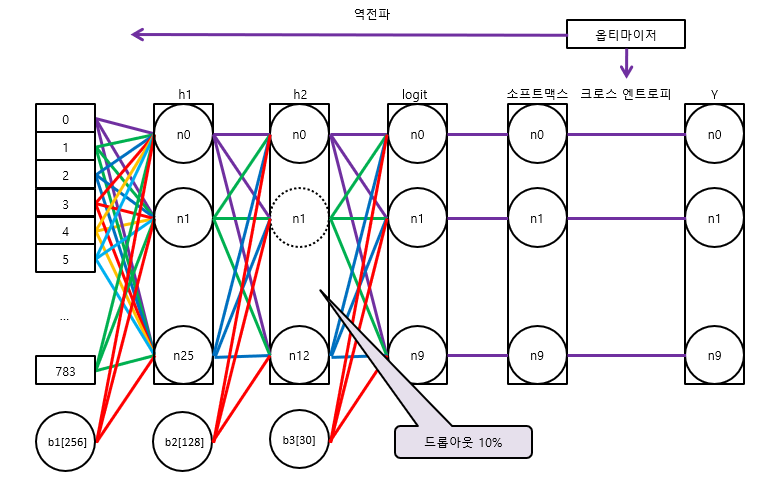

                            <설계한 모델 이미지>

+ 입력 데이터는 784개의 숫자가 들어있는 배열이다.  
+ 784개의 입력을 받는 256개의 노드가 1번째 레이어에 있고 1번째 레이어의 출력값을 입력으로 받는 2번째 레이어에는 128개의 노드가 있다. 2번째 레이어에 10% 드롭아웃을 적용하고 2번째 레이어의 출력을 받는 3번째 레이어에는 총 10개의 노드가 존재하며 이 10개의 노드값은 소프트맥스를 통과해서 0부터 9까지에 해당하는 각 숫자의 확률을 의미하게 된다.

In [11]:
# 1번째 차원이 None인 이유는 데이터 개수 제약없이 입력받기 위해서이고
# 2번째 차원이 784인 것은 MNIST의 이미지 크기가 28 * 28 픽셀 = 784 픽셀이기 떄문이다 
# x : 입력값, y : 출력값, keep_prob : 드롭아웃 적용 변수
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32)


In [21]:
# 다중 퍼셉트론 구현함수
def mlp(x):
    
    # 히든 레이어1
    w1 = tf.Variable(tf.random_uniform([784,256]))
    b1 = tf.Variable(tf.zeros([256]))
    h1 = tf.nn.relu(tf.matmul(x, w1) + b1)
    
    # 히든 레이어2
    w2 = tf.Variable(tf.random_uniform([256,128]))
    b2 = tf.Variable(tf.zeros([128]))
    h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)
    
    # 드롭아웃 적용
    # keep_prob만 썼는데 버전이 올라가면서 rate=1-keep_prob 형태로 작성해야함
    h2_drop = tf.nn.dropout(h2, rate=1-keep_prob)
    
    # 히든 레이어3
    w3 = tf.Variable(tf.random_uniform([128,10]))
    b3 = tf.Variable(tf.zeros([10]))
    h3 = tf.nn.relu(tf.matmul(h2_drop, w3) + b3)
    
    return h3
    

다층 퍼셉트론의 출력값을 logits로 정의한다.

logit => logistic과 probit의 합성어로 probit은 확률을 재는 단위라는 뜻이다.

In [22]:
logits = mlp(x)

### 4.3. 손실함수로 크로스엔트로피 사용

logits와 실제값이 크로스 엔트로피를 손실 함수로 사용한다.

In [23]:
# 크로스 엔트로피 공신인
# tf.reduce_mean(-tf.reduce_sum(y*tf.log(tf.nn.softmax(logits)), reduction_indices=1))
# 을 그대로 사용하면 수치적으로 불안정하여 계산 오류가 발생할 수 있음

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))


### 4.4. 매개변수 최적화로 소프트맥스 사용

+ 소프트맥스 출력값과 실제값의 차이를 계산하기 위해 크로스 엔트로피를 손실 함수로 사용하고 손실 함수를 최소화하기 위해 Adam 옵티마이저를 사용해 역전파를 통해 모든 가중치 및 편향값을 최적화한다.  
+ 최적화 함수 참고 : https://onevision.tistory.com/entry/Optimizer-%EC%9D%98-%EC%A2%85%EB%A5%98%EC%99%80-%ED%8A%B9%EC%84%B1-Momentum-RMSProp-Adam
+ 소프트맥스는 분류해야하는 정답지(클래스)의 총 개수를 k라고 할 때 k차원의 벡터를 입력받아 각 클래스에 대한 확률을 추정한다.

In [24]:
# Adam 옵티마이저를 사용해 모델을 최적화한다
# 모델의 최적화 과정은 모델의 예측값과 실제값의 차이를 줄여나가는 과정을 의미함
train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss_op)


## 5. 학습 및 검증

### 5.1. 변수 선언

+ 조기 종료는 과대적합을 피하고 충분한 학습을 하기 위해 학습 중간마다 검증 데이터에 대한 정확도를 측정해 학습 정확도는 계속 증가하는 반면 검증 데이터에 대한 정확도가 점차 멀어질 경우 중지하는 것을 말한다.
+ 매 주기(epoch)마다 검증 데이터로 검증 정확도를 측정한다.
+ 검증 정확도가 5번 연속으로 최고 검증 정확도보다 높지 않을 경우 조기 종료를 수행한다.

In [25]:
# 텐서플로우 변수 초기화
init = tf.global_variables_initializer()

# 텐서플로우 모델의 저장 및 로드에 사용할 변수를 선언함
saver = tf.train.Saver()

# 조기 종료가 일어나지 않을 경우 최대 300번까지 반복해서 학습하도록 설정함
epoch_cnt = 300

# 1번에 처리할 데이터의 개수를 설정함
batch_size = 1000

# batch_size 에 따른 학습 반복 횟수를 설정함
iteration = len(x_train) // batch_size

# 검증 정확도가 최고 정확도보다 5번 연속으로 높지 않을 경우 조기 종료하도록 설정함
earlystop_threshold = 5

# 검증 정확도가 최고 정확도보다 연속으로 높지 않은 횟수를 세는 변수를 선언함
earlystop_cnt = 0


### 5.2. 학습

+ 데이터를 모델에 입력할 때 모델에 드롭아웃이 적용된 경우 항상 keep_prob을 설정해야한다.
+ 학습 시 10%의 드롭아웃을 적용하기 위해 keep_prop을 0.9로 설정하고 테스트할 때는 드롭아웃을 적용하지 않을 것이므로 keep_prob를 1.0으로 설정한다.

In [26]:
# tf.argmax() 메소드는 배열에서 가장 큰 값을 찾아서 그 인덱스를 리턴한다.
# tf.argmax() 메소드를 2차원 배열에서 실행할 때 2번째 인수로 0을 지정하면 각 열에서 가장 큰 값을 찾아 그 인덱스를 리턴한다.
# tf.argmax() 메소드를 2차원 배열에서 실행할 때 2번째 인수로 1을 지정하면 각 행에서 가장 큰 값을 찾아 그 인덱스를 리턴한다.

a = tf.constant([3, 10, 1])                         # 1차원 배열
b = tf.constant([[3, 10, 1], [4, 5, 6], [0, 8, 7]]) # 2차원 배열
sess = tf.Session()
print(sess.run(tf.argmax(a, 0)))  # a 배열에서 10이 가장 크기 때문에 결과는 10의 인덱스인 1이 출력된다.
print(sess.run(tf.argmax(b, 0)))
print(sess.run(tf.argmax(b, 1)))


1
[1 0 2]
[1 2 1]


In [28]:
with tf.Session() as sess:
    sess.run(init)          # 텐서플로우 변수 초기화
    prev_train_acc = 0.0    # 이전 학습 정확도를 기억하는 변수를 선언함
    max_val_acc = 0.0       # 검증 정확도의 최대값을 기억하는 변수를 선언함
    
    # 지정된 최대 epoch 만큼 학습함
    # 검증 정확도가 최고 정확도보다 5번 연속으로 높지 않을 경우 학습을 조기 종료함
    for epoch in range(epoch_cnt):
        avg_loss = 0.0      # 손실값
        start = 0           # 학습 시작 위치
        end = batch_size    # 학습 끝 위치
        
        
        # 1. 학습 데이터를 batch_size 개씩 나눠 학습을 진행한다.
        for i in range(iteration):
            _, loss = sess.run([train_op, loss_op], 
                               feed_dict={x: x_train[start:end], y: y_train[start:end], keep_prob: 0.9})
            start += batch_size
            end += batch_size
            # 크로스 엔트로피 손실 함수의 학습 손실값을 계산한다.
            avg_loss += loss / iteration
        
        
        # 2. 모델 검증
        preds = tf.nn.softmax(logits) # 소프트맥스 적용
        correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y, 1))
        
        
        # 3. 정확도 계산
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        
        # 3.1. 학습 정확도 계산
        # Session.run()과 Tensor.eval()의 차이
        # t가 Tensor 오브젝트라면 t.eval()은 sess.run(t)의 속기 표현이다.(sess가 현재 디폴트 세션인 곳에서만)
        cur_train_acc = accuracy.eval({x: x_train, y: y_train, keep_prob: 1.0})
        
        # 3.2. 검증 정확도 계산
        cur_val_acc = accuracy.eval({x: x_val, y: y_val, keep_prob: 1.0})
        
        # 검증 데이터에 대한 손실값 계산
        cur_val_loss = loss_op.eval({x: x_val, y: y_val, keep_prob: 1.0})
        
        # 학습 정확도와 검증 정확도를 출력한다.
        print('epoch: {0:3d}, 학습 정확도: {1:7.5f}, 검증 정확도: {2:7.5f}'.format(epoch, cur_train_acc, cur_val_acc))
        
        
         # 4. 현재 검증 정확도와 검증 정확도의 최대값을 비교한다.
        if cur_val_acc < max_val_acc:
            
            # 현재 검증 정확도가 검증 정확도의 최대값 미만이면
            # 현재 학습 정확도와 이전 학습 정확도, 현재 학습 정확도와 0.99를 비교한다.
            if cur_train_acc > prev_train_acc or cur_train_acc > 0.99:
                
                # 현재 학습 정확도가 이전 학습 정확도 보다 크거나 현재 학습 정확도가 0.99 보다 크면
                if earlystop_cnt == earlystop_threshold:
                    # 5번 연속으로 현재 학습 정확도가 이전 학습 정확도 보다 크면 조기 종료한다.
                    print('조기 종료 시점: {}'.format(epoch))
                    break
                else:
                    # 5번 연속으로 현재 학습 정확도가 이전 학습 정확도 보다 크지 않다면 이전 학습 정확도가 현재 학습 정확도
                    # 보다 크므로 현재 검증 정확도가 최고 정확도의 최대값보다 연속으로 높지 않은 횟수를 카운트 하는 변수를
                    # 1증가 시킨다.
                    print('과대적합 경고 횟수: {}'.format(earlystop_cnt))
                    earlystop_cnt += 1
                # ============================================
            
            else:
                # 현재 학습 정확도가 이전 학습 정확도 보다 작거나, 현재 학습 정확도가 0.99 이하이면
                # 이전 학습 정확도가 현재 학습 정확도 이상이므로 현재 검증 정확도가 정확도의 최대값 보다 연속으로 높지 않은
                # 횟수를 카운트하는 변수를 다시 0으로 초기화시킨다.
                earlystop_cnt = 0
            # ============================================
        
        else:
            # 현재 검증 정확도가 검증 정확도의 최대값 이상이면
            # 현재 검증 정확도가 검증 정확도의 최대값 보다 연속으로 높지 않은 횟수를 카운트 하는 변수를 다시 0으로 초기화
            # 시킨다.
            earlystop_cnt = 0
            # 검증 정확도의 최대값을 현재 검증 정확도로 교체한다.
            max_val_acc = cur_val_acc
            # 검증 정확도가 가장 높은 모델을 저장한다.
            save_path = saver.save(sess, './model/model.ckpt')
        # ============================================
        
        # 5. 다음 학습을 위해 현재 학습 정확도를 이전 학습 정확도를 기억하는 변수에 넣어준다.
        prev_train_acc = cur_train_acc
        

epoch:   0, 학습 정확도: 0.18882, 검증 정확도: 0.19820
epoch:   1, 학습 정확도: 0.49418, 검증 정확도: 0.50740
epoch:   2, 학습 정확도: 0.57410, 검증 정확도: 0.59870
epoch:   3, 학습 정확도: 0.62146, 검증 정확도: 0.64280
epoch:   4, 학습 정확도: 0.66610, 검증 정확도: 0.68700
epoch:   5, 학습 정확도: 0.70878, 검증 정확도: 0.72710
epoch:   6, 학습 정확도: 0.73750, 검증 정확도: 0.75600
epoch:   7, 학습 정확도: 0.76580, 검증 정확도: 0.77900
epoch:   8, 학습 정확도: 0.78622, 검증 정확도: 0.79730
epoch:   9, 학습 정확도: 0.80452, 검증 정확도: 0.81700
epoch:  10, 학습 정확도: 0.82038, 검증 정확도: 0.83130
epoch:  11, 학습 정확도: 0.83494, 검증 정확도: 0.84450
epoch:  12, 학습 정확도: 0.84708, 검증 정확도: 0.85370
epoch:  13, 학습 정확도: 0.85814, 검증 정확도: 0.86310
epoch:  14, 학습 정확도: 0.86708, 검증 정확도: 0.87010
epoch:  15, 학습 정확도: 0.87638, 검증 정확도: 0.87680
epoch:  16, 학습 정확도: 0.88288, 검증 정확도: 0.88310
epoch:  17, 학습 정확도: 0.88916, 검증 정확도: 0.88900
epoch:  18, 학습 정확도: 0.89430, 검증 정확도: 0.89450
epoch:  19, 학습 정확도: 0.89886, 검증 정확도: 0.89920
epoch:  20, 학습 정확도: 0.90176, 검증 정확도: 0.90030
epoch:  21, 학습 정확도: 0.90632, 검증 정확도: 0.90280
epoch:  22

epoch: 168, 학습 정확도: 0.98924, 검증 정확도: 0.95570
epoch: 169, 학습 정확도: 0.98872, 검증 정확도: 0.95600
epoch: 170, 학습 정확도: 0.98790, 검증 정확도: 0.95440
epoch: 171, 학습 정확도: 0.98682, 검증 정확도: 0.95460
epoch: 172, 학습 정확도: 0.98912, 검증 정확도: 0.95570
과대적합 경고 횟수: 0
epoch: 173, 학습 정확도: 0.98888, 검증 정확도: 0.95460
epoch: 174, 학습 정확도: 0.99018, 검증 정확도: 0.95600
과대적합 경고 횟수: 0
epoch: 175, 학습 정확도: 0.98968, 검증 정확도: 0.95510
epoch: 176, 학습 정확도: 0.99138, 검증 정확도: 0.95700
과대적합 경고 횟수: 0
epoch: 177, 학습 정확도: 0.99094, 검증 정확도: 0.95720
과대적합 경고 횟수: 1
epoch: 178, 학습 정확도: 0.98930, 검증 정확도: 0.95530
epoch: 179, 학습 정확도: 0.99142, 검증 정확도: 0.95760
과대적합 경고 횟수: 0
epoch: 180, 학습 정확도: 0.99166, 검증 정확도: 0.95790
epoch: 181, 학습 정확도: 0.98972, 검증 정확도: 0.95620
epoch: 182, 학습 정확도: 0.99150, 검증 정확도: 0.95640
과대적합 경고 횟수: 0
epoch: 183, 학습 정확도: 0.99022, 검증 정확도: 0.95580
과대적합 경고 횟수: 1
epoch: 184, 학습 정확도: 0.98970, 검증 정확도: 0.95620
epoch: 185, 학습 정확도: 0.98990, 검증 정확도: 0.95620
과대적합 경고 횟수: 0
epoch: 186, 학습 정확도: 0.98968, 검증 정확도: 0.95610
epoch: 187, 학습 정확도: 0.98794, 검증 정

## 6. 테스트

In [29]:
with tf.Session() as sess:
    # 검증 결과가 가장 높았던 모델을 불러온다.
    saver.restore(sess, './model/model.ckpt')
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y, 1))
    
    # 정확도 계산
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    print('정확도: {}'.format(accuracy.eval({x: x_train, y: y_train, keep_prob: 1.0})))


INFO:tensorflow:Restoring parameters from ./model/model.ckpt
정확도: 0.9937000274658203
